# COGS 189: Final Project
### Members: Ehson Pirouzian, ... write your own

This is our Winter 2022 Final Project for COGS 189
The purpose is a machine learning project that relates to motor sensory data from BCI competition IV dataset 2a

### Hypothesis

Is it easiest to classify data left hand sensory data against right hand, foot, or tounge sensory data?

### Code

We will use matlab and python for how we test our hypothesis


#### Importing the data

In [257]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
import scipy.io as sio
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [258]:

def get_data(subject,training,PATH):
	NO_channels = 22
	NO_tests = 6*48 	
	Window_Length = 7*250 

	class_return = np.zeros(NO_tests)
	data_return = np.zeros((NO_tests,NO_channels,Window_Length))

	NO_valid_trial = 0
	if training:
		a = sio.loadmat(PATH+'A0'+str(subject)+'T.mat')
	else:
		a = sio.loadmat(PATH+'A0'+str(subject)+'E.mat')
	a_data = a['data']
	for ii in range(0,a_data.size):
		a_data1 = a_data[0,ii]
		a_data2=[a_data1[0,0]]
		a_data3=a_data2[0]
		a_X 		= a_data3[0]
		a_trial 	= a_data3[1]
		a_y 		= a_data3[2]
		a_fs 		= a_data3[3]
		a_classes 	= a_data3[4]
		a_artifacts = a_data3[5]
		a_gender 	= a_data3[6]
		a_age 		= a_data3[7]
		for trial in range(0,a_trial.size):
			if(a_artifacts[trial]==0):
				data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+Window_Length),:22])
				class_return[NO_valid_trial] = int(a_y[trial])
				NO_valid_trial +=1


	return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]
	

# Now we will import each of the 9 training files
df1, classes1 = get_data("1",True,"./dataset2a/")
df2, classes2 = get_data("2",True,"./dataset2a/")
df3, classes3 = get_data("3",True,"./dataset2a/")
df4, classes4 = get_data("4",True,"./dataset2a/")
df5, classes5 = get_data("5",True,"./dataset2a/")
df6, classes6 = get_data("6",True,"./dataset2a/")
df7, classes7 = get_data("7",True,"./dataset2a/")
df8, classes8 = get_data("8",True,"./dataset2a/")
df9, classes9 = get_data("9",True,"./dataset2a/")


In [259]:
# 4 classes, #some number of tests, 3 channels, 1750 datapoints each
# this will become 4 different dataframes for each class with 3 channels and #tests for each channel * datapoints

df1 = df1[:,(7,9,11),:]
df2 = df2[:,(7,9,11),:]
df3 = df3[:,(7,9,11),:]
df4 = df4[:,(7,9,11),:]
df5 = df5[:,(7,9,11),:]
df6 = df6[:,(7,9,11),:]
df7 = df7[:,(7,9,11),:]
df8 = df8[:,(7,9,11),:]
df9 = df9[:,(7,9,11),:]



In [260]:
def channelNames(data):
    for x in data['chs']:
        chname = x["ch_name"].strip('EEG-')
        x['ch_name']= chname
    return data
    

In [261]:
# Get the raw value
raw = mne.io.read_raw_gdf('./BCICIV_2a_gdf/A01T.gdf', preload=True)

eegbci.standardize(raw)  # set channel names

# raw.info = channelNames(raw.info)
# print(raw.info['chs'])

Extracting EDF parameters from /Users/ehson/Documents/Classes/COGS189/Cogs-189-Project/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Users/ehson/miniconda3/envs/cogs/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/ehson/miniconda3/envs/cogs/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [262]:
#raw.rename_channels(lambda x: x.strip('.'))
montage = mne.channels.make_standard_montage('standard_1005')
# print(montage)
# montage.ch_names = chList
# print(montage.ch_names)
raw.set_montage(montage, on_missing='ignore')

raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [263]:
mne.events_from_annotations(raw)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 29683,      0,      5],
        ...,
        [670550,      0,      6],
        [670550,      0,      1],
        [671050,      0,      7]]),
 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10})

In [264]:
def filterEventsLeft_Foot(events):
    finalArray = []
    for event in events:
        if event[2] == 8 or event[2] == 9:
            finalArray.append(event)
    return finalArray

events, _ = events_from_annotations(raw)
events = filterEventsLeft_Foot(events)
pprint(events)

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

event_id = dict(hands=8, feet=9)
epochs = Epochs(raw, events, event_id, 0, 6, proj=True, picks=picks, baseline=None, preload=True)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
[array([94371,     0,     9]),
 array([96289,     0,     8]),
 array([102360,      0,      8]),
 array([104277,      0,      9]),
 array([108258,      0,      8]),
 array([110256,      0,      9]),
 array([119940,      0,      8]),
 array([122060,      0,      8]),
 array([128170,      0,      9]),
 array([132306,      0,      8]),
 array([138329,      0,      9]),
 array([146351,      0,      8]),
 array([152423,      0,      8]),
 array([156622,      0,      8]),
 array([158713,      0,      9]),
 array([160756,      0,      9]),
 array([162820,      0,      9]),
 array([166812,      0,      9]),
 array([172781,      0,      8]),
 array([174759,      0,      9]),
 array([176749,      0,      8]),
 array([178868,      0,      9]),
 array([182702,      0,      8]),
 array([184816,      0,      9]),
 array([195076,      0,      8]),
 array([199195,      0,      9]),
 array([203162, 

In [265]:
epochs_train = epochs.copy().crop(tmin=3., tmax=6.)
labels = epochs.events[:, -1] - 2

print(epochs_train.get_data())

[[[-3.44700277e-06 -2.13753330e-06 -5.61083720e-07 ...  9.83473365e-07
    2.25604709e-07  2.88445034e-07]
  [-2.67763657e-06 -1.48582961e-06  1.41542370e-07 ...  1.86051209e-06
    1.52150544e-06  1.72871419e-06]
  [-4.54945197e-06 -3.56203009e-06 -1.85406704e-06 ...  1.50518147e-06
    4.86851338e-07  1.58904534e-07]
  ...
  [-3.00310112e-06 -2.70225135e-06 -1.98118446e-06 ...  1.87645941e-06
    1.90571753e-06  1.96491276e-06]
  [-1.49453752e-06 -2.30273604e-07  1.49750109e-06 ... -1.94844029e-06
   -5.32675166e-07  1.16506419e-06]
  [-5.25239341e-06 -4.49049231e-06 -2.38892161e-06 ...  3.51289978e-06
    3.97159915e-06  3.12118356e-06]]

 [[ 5.58269629e-06  7.04832897e-06  7.67640137e-06 ...  1.00797901e-05
    7.88472375e-06  5.44001451e-06]
  [ 5.24283269e-06  6.28291640e-06  5.64526752e-06 ...  8.59928594e-06
    5.94580352e-06  3.40484658e-06]
  [ 7.80580027e-06  9.65746233e-06  9.64853803e-06 ...  1.01492503e-05
    8.63167979e-06  6.64637887e-06]
  ...
  [ 8.73116487e-07  2.1

In [266]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)
cv_split = cv.split(epochs_data_train)

In [267]:

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 2.6e-05 (2.2e-16 eps * 25 dim * 4.6e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-05 (2.2e-16 eps * 25 dim * 4.7e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-05 (2.2e-16 eps * 25 dim * 4.3e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)


In [268]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.700000 / Chance level: 0.500000


In [269]:
print(epochs.info)
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

# csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
>
Computing rank from data with rank=None
    Using tolerance 4.4e-05 (2.2e-16 eps * 25 dim * 7.9e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00029 (2.2e-16 eps * 25 dim * 5.2e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.


array([[-7.51964142e+00, -2.75474541e-01, -1.71459016e-01,
        -6.22461067e-02],
       [-7.35658325e+00, -6.74653050e-01, -9.37835641e-01,
        -9.32551301e-01],
       [-7.46928448e+00, -5.64937546e-01, -7.60305611e-01,
        -7.23606754e-01],
       [-7.34152534e+00,  1.81751588e-04, -2.90826536e-01,
        -4.23302278e-01],
       [-7.50606309e+00, -1.12681167e+00, -1.31958284e+00,
        -1.06719742e+00],
       [-7.37477405e+00, -6.96101436e-01, -5.46776511e-01,
        -6.98435047e-01],
       [-7.48027834e+00, -1.24312070e+00, -9.76439554e-01,
        -1.17578493e+00],
       [-7.44775281e+00, -1.01931219e+00, -1.33485403e+00,
        -1.11938766e+00],
       [-7.51402584e+00, -8.20431781e-01, -7.41251114e-01,
        -2.43665467e-01],
       [-7.20233497e+00, -9.56891794e-01, -8.98609806e-01,
        -5.43982932e-01],
       [-7.06118813e+00, -6.57010064e-01, -1.00379779e+00,
        -9.23454081e-01],
       [-7.07573289e+00, -1.20636073e+00, -1.17327909e+00,
      

In [270]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [271]:

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

Computing rank from data with rank=None
    Using tolerance 2.6e-05 (2.2e-16 eps * 25 dim * 4.6e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-05 (2.2e-16 eps * 25 dim * 4.7e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-05 (2.2e-16 eps * 25 dim * 4.3e+09  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 25 dim * 3.7e+10  max singular value)


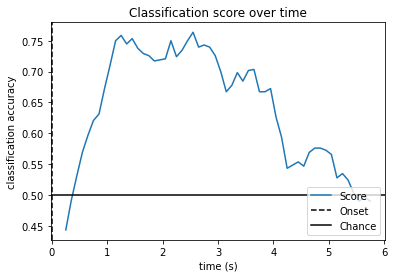

In [272]:

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()